In [1]:
import torch
import random
import numpy as np
from torch import no_grad
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizerFast, BertForMaskedLM, AdamW, get_scheduler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths to your corpus files
task_file_path = '/content/drive/MyDrive/Capstone Project Data/Task-Level Corpora/Joined Task-Level.txt'
entity_file_path = '/content/drive/MyDrive/Capstone Project Data/Entity-Level Corpora/Joined Entity-Level.txt'
output_file_path = '/content/drive/MyDrive/Capstone Project Data/DAPT Dataset/Combined_Corpus.txt'

In [4]:
def load_text_file(file_path):
    """ Load text from a file """
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

In [5]:
def create_span_masks(token_ids, tokenizer, max_length=True, span_length=5, mask_prob=0.15):
    """ Create span-level masks for a list of token IDs """
    token_ids = torch.tensor(token_ids, dtype=torch.long)
    num_to_mask = int(token_ids.size(0) * mask_prob)
    output_ids = token_ids.clone()
    num_masked = 0

    while num_masked < num_to_mask:
        span = min(span_length, num_to_mask - num_masked)
        start = random.randint(0, token_ids.size(0) - span)

        # Skip if span overlaps with previously masked tokens
        if any(output_ids[start:start + span] == tokenizer.mask_token_id):
            continue

        # Mask the tokens
        for i in range(start, start + span):
            if num_masked >= num_to_mask:
                break
            rand = random.random()
            if rand < 0.8:
                output_ids[i] = tokenizer.mask_token_id
            elif rand < 0.9:
                output_ids[i] = random.randint(0, tokenizer.vocab_size - 1)
            num_masked += 1

    # Apply padding
    if output_ids.size(0) < max_length:
        padding_length = max_length - output_ids.size(0)
        padding_tensor = torch.full((padding_length,), tokenizer.pad_token_id, dtype=torch.long)
        output_ids = torch.cat([output_ids, padding_tensor])

    return output_ids


In [6]:
# Load the combined corpus
combined_corpus_path = '/content/drive/MyDrive/Capstone Project Data/DAPT Dataset/Combined_Corpus.txt'
text_data = load_text_file(combined_corpus_path)

In [7]:
# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize and apply span-level masking
tokenized_data = tokenizer.encode(text_data, add_special_tokens=True, max_length=512, truncation=True)
masked_tokens = create_span_masks(tokenized_data, tokenizer, max_length=True, span_length=3, mask_prob=0.15)

print("Tokenized Data Sample:", tokenized_data[:512])
print("Masked Tokens Sample:", masked_tokens[:512])

In [ ]:
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.train()

In [ ]:
# Prepare data
inputs = tokenizer(text_data, return_tensors="pt", max_length=512, padding="max_length", truncation=True)
inputs['labels'] = inputs.input_ids.detach().clone()
inputs.input_ids = torch.stack([
    create_span_masks(tok_ids.tolist(), tokenizer, max_length=512)
    for tok_ids in inputs.input_ids
])

print(inputs.input_ids)

In [11]:
dataset = TensorDataset(inputs.input_ids, inputs.attention_mask, inputs['labels'])
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [12]:
# Setup optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Number of training epochs
epochs = 50
num_training_steps = epochs * len(dataloader)

In [14]:
# Setup learning rate scheduler (optional)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [15]:
# Prepare for training
progress_bar = tqdm(range(num_training_steps))
model.train()

for epoch in range(epochs):
    for batch in dataloader:

        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(model.device)
        attention_mask = attention_mask.to(model.device)
        labels = labels.to(model.device)

        # Clear any previously calculated gradients
        optimizer.zero_grad()

        # Forward pass: compute predictions and loss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update optimizer and learning rate scheduler
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.update(1)

    # Print loss for each epoch
    print(f"Epoch {epoch + 1}: Loss {loss.item()}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Loss 0.831851601600647
Epoch 2: Loss 0.7441369295120239
Epoch 3: Loss 0.6998651623725891
Epoch 4: Loss 0.6211807131767273
Epoch 5: Loss 0.5931463837623596
Epoch 6: Loss 0.5532999634742737
Epoch 7: Loss 0.5009593367576599
Epoch 8: Loss 0.5054885149002075
Epoch 9: Loss 0.44765719771385193
Epoch 10: Loss 0.4426524341106415
Epoch 11: Loss 0.3956938087940216
Epoch 12: Loss 0.3934617340564728
Epoch 13: Loss 0.3417137861251831
Epoch 14: Loss 0.3239516317844391
Epoch 15: Loss 0.33099085092544556
Epoch 16: Loss 0.28007152676582336
Epoch 17: Loss 0.2885969281196594
Epoch 18: Loss 0.2572158873081207
Epoch 19: Loss 0.2614728510379791
Epoch 20: Loss 0.22216863930225372
Epoch 21: Loss 0.22456064820289612
Epoch 22: Loss 0.23104096949100494
Epoch 23: Loss 0.20100778341293335
Epoch 24: Loss 0.1780041754245758
Epoch 25: Loss 0.18827268481254578
Epoch 26: Loss 0.19099655747413635
Epoch 27: Loss 0.1551821529865265
Epoch 28: Loss 0.16588398814201355
Epoch 29: Loss 0.16636724770069122
Epoch 30: Los

# **Evaluation**

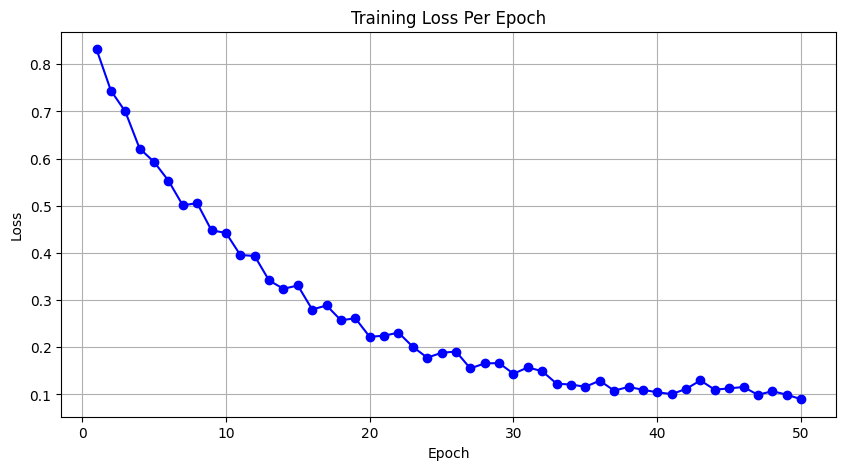

In [1]:
import matplotlib.pyplot as plt

# Defining epochs and loss values
epochs = list(range(1, 51))
loss_values = [
    0.831851601600647, 0.7441369295120239, 0.6998651623725891, 0.6211807131767273, 0.5931463837623596,
    0.5532999634742737, 0.5009593367576599, 0.5054885149002075, 0.44765719771385193, 0.4426524341106415,
    0.3956938087940216, 0.3934617340564728, 0.3417137861251831, 0.3239516317844391, 0.33099085092544556,
    0.28007152676582336, 0.2885969281196594, 0.2572158873081207, 0.2614728510379791, 0.22216863930225372,
    0.22456064820289612, 0.23104096949100494, 0.20100778341293335, 0.1780041754245758, 0.18827268481254578,
    0.19099655747413635, 0.1551821529865265, 0.16588398814201355, 0.16636724770069122, 0.1439235806465149,
    0.15734051167964935, 0.14920294284820557, 0.12286072224378586, 0.12095947563648224, 0.11624395847320557,
    0.12921667098999023, 0.10805800557136536, 0.11592993885278702, 0.1098737120628357, 0.104543536901474,
    0.10076059401035309, 0.11165610700845718, 0.1296800971031189, 0.11004039645195007, 0.1129010021686554,
    0.11574511975049973, 0.09918379783630371, 0.10690951347351074, 0.09950952231884003, 0.08986596763134003
]

# Creating the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
